In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
# generate signal
def generate_signal(omega, t, x0=np.float64(0)):
    
    # Get angle that should be swept
    angle_to_sweep = x0 + omega*t
    
    # Get the angle b/w limits
    normalized_angle = np.mod(angle_to_sweep, 2*np.pi)
    # Return answer
    if(np.allclose(normalized_angle, 2*np.pi, rtol=1e-5)):
        x = 0
    else:
        x = normalized_angle
    return x

In [3]:
def sample_signal(omega, Fs, tfinal):
    
    # Sample uniformly ts
    step = 1/Fs
    ts = np.arange(0, tfinal, step, dtype=np.float32)
    
    # Get xs for given ts
    xs = np.float32(generate_signal(omega, ts))
    
    return (xs, ts)


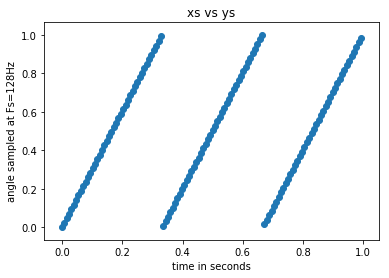

In [4]:
omega = 2*np.pi*(2+1)
Fs = 128
xs, ts = sample_signal(omega, Fs, 1)

xs /= np.max(xs)

plt.title('xs vs ys')
plt.xlabel('time in seconds')
plt.ylabel('angle sampled at Fs=128Hz')
plt.scatter(ts, xs)
plt.show()

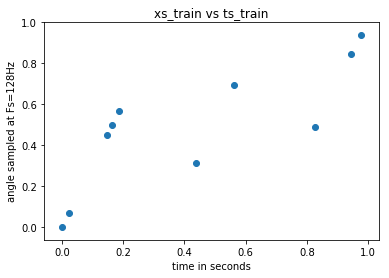

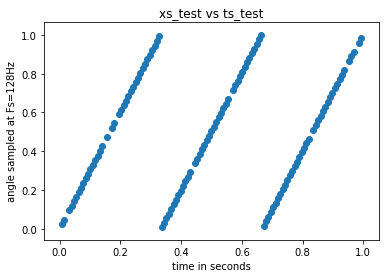

In [5]:
np.random.seed(1+2)
idx = np.sort(np.random.randint(len(xs), size=10))
xs_train = xs[idx]
ts_train = ts[idx]

xs_test =  np.delete(xs, idx)
ts_test =  np.delete(ts, idx)

plt.title('xs_train vs ts_train')
plt.xlabel('time in seconds')
plt.ylabel('angle sampled at Fs=128Hz')
plt.scatter(ts_train, xs_train)
plt.show()

plt.title('xs_test vs ts_test')
plt.xlabel('time in seconds')
plt.ylabel('angle sampled at Fs=128Hz')
plt.scatter(ts_test, xs_test)
plt.show()

In [6]:
def gradient_descent(order_of_model, data_xs_ts, learning_rate = 0.01, init_coefs = None, lambda_coefs=0):
    
    powers = np.arange(0, order_of_model+1, 1)
    
    #initialize weights
    if(init_coefs==None):
        init_coefs = np.random.rand(order_of_model+1)
    
    for i in range(10000):
        
        #define the input matrix
        
        phi = np.power(np.float32([data_xs_ts[1]]).T , powers)
        ys = np.matmul(phi, np.float32([init_coefs]).T)
        
        err = data_xs_ts[0] - np.ravel(ys)
        grad = -2*np.matmul(np.float32([err]), phi) + lambda_coefs*np.sign(init_coefs)
        
        if(np.allclose(grad, 1e-4)):
            return(init_coefs)
        init_coefs = init_coefs - np.ravel(grad)*learning_rate
    return(init_coefs)

In [7]:
def linear_square_method(order_of_model, data_xs_ts, lambda_coefs):
    powers = np.arange(0, order_of_model+1, 1)
    
    #define the input matrix
    phi = np.power(np.float32([data_xs_ts[1]]).T , powers)
    
    weights = np.matmul(np.matmul(np.linalg.inv(np.matmul(phi.T, phi)), np.subtract(phi.T, lambda_coefs)), np.float32([data_xs_ts[0]]).T)
    
    return(weights)

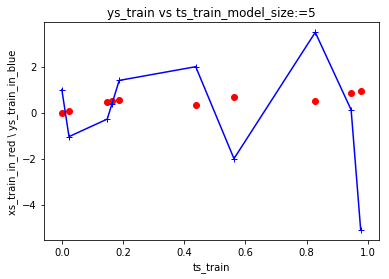

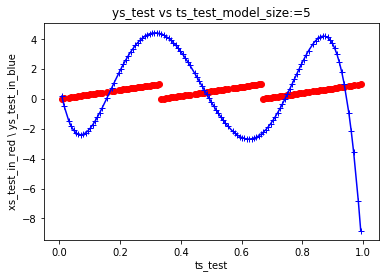

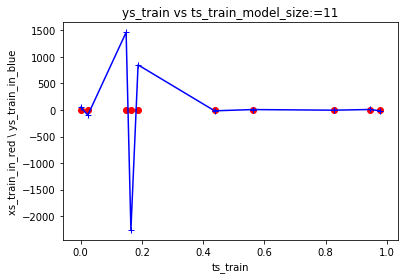

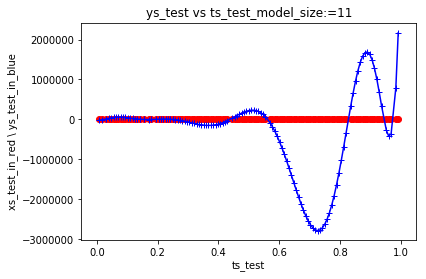

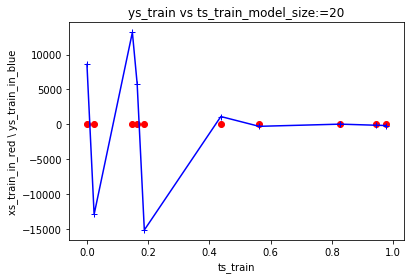

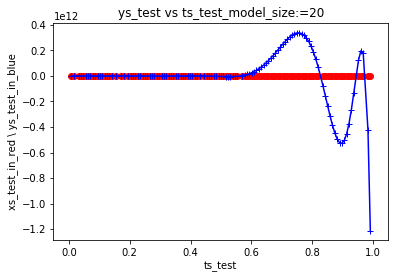

In [8]:
# with LASSO
for i in [5, 11, 20]:
    weights = linear_square_method(i, [xs_train, ts_train], lambda_coefs=1)
    
    ys_train = np.polynomial.polynomial.polyval(ts_train, np.ravel(weights))
#     print(ys_train-xs_train)
    plt.title('ys_train vs ts_train_model_size:='+str(i))
    plt.xlabel('ts_train')
    plt.ylabel('xs_train_in_red \\ ys_train_in_blue')
    plt.scatter(ts_train, xs_train, c='red', marker='o')
    plt.plot(ts_train, ys_train, c='blue', marker='+')
    plt.show()
    
    ys_test = np.polynomial.polynomial.polyval(ts_test, np.ravel(weights))
#     print(ys_train-xs_train)
    plt.title('ys_test vs ts_test_model_size:='+str(i))
    plt.xlabel('ts_test')
    plt.ylabel('xs_test_in_red \\ ys_test_in_blue')
    plt.scatter(ts_test, xs_test, c='red', marker='o')
    plt.plot(ts_test, ys_test, c='blue', marker='+')
    plt.show()

In [29]:
Ed_train = []
Ed_test = []
we= []
for i in np.arange(0, 1, 0.001):
    print(i)
    weights = gradient_descent(10, [xs_train, ts_train], lambda_coefs=i)
    we.append(weights)
    w = np.sort(abs(weights))[:math.floor(len(weights)/2)]
    print(w)
    ys_train = np.polynomial.polynomial.polyval(ts_train, np.ravel(weights))
    err = np.sum(np.square(xs_train-ys_train))
    Ed_train.append([err, i])
    
    ys_test = np.polynomial.polynomial.polyval(ts_test, np.ravel(weights))
    err = np.sum(np.square(xs_test-ys_test))
    Ed_test.append([err, i])
    
    if len(np.where(abs(weights)<1e-3)[0])==math.ceil(len(weights)/2):
        break

0.0
[0.05441548 0.06290252 0.1096723  0.26009409 0.32122088]
0.001
[9.13437807e-06 2.16646499e-02 1.12647931e-01 1.15923126e-01
 1.23652843e-01]
0.002
[0.00849042 0.03788656 0.11150895 0.12117581 0.18620068]
0.003
[0.01616127 0.08714855 0.09383512 0.11735769 0.19731507]
0.004
[3.29465582e-06 1.81785074e-02 2.02640067e-02 2.19048063e-02
 1.21976472e-01]
0.005
[0.00275689 0.01862045 0.03948804 0.09485219 0.12018765]
0.006
[7.00010767e-05 4.71802210e-03 9.67245558e-02 1.23504467e-01
 2.57307712e-01]
0.007
[7.37964853e-05 1.23585167e-04 9.61340938e-03 1.25697120e-01
 2.23359926e-01]
0.008
[1.69495221e-05 5.70006662e-05 7.90409451e-04 6.95872524e-03
 1.04886060e-01]
0.009000000000000001
[1.00265068e-05 1.84215951e-05 1.33647555e-04 3.50909255e-02
 5.02229985e-02]
0.01
[7.83016864e-06 4.04340042e-05 1.05356015e-04 1.06091102e-04
 1.30262057e-01]
0.011
[9.24783934e-06 4.01184800e-05 1.46827487e-04 1.83009087e-04
 2.72187478e-02]
0.012
[1.12562041e-05 4.02157830e-05 7.79726948e-05 2.13678810e-

In [27]:
np.arange(0, 1, 0.01).shape

(100,)

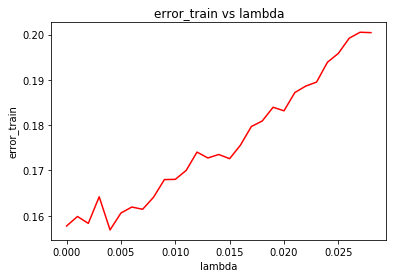

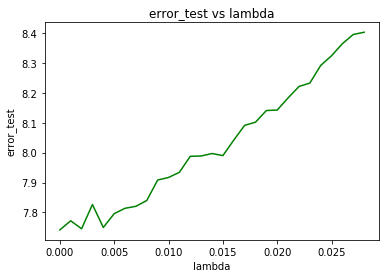

In [16]:
plt.plot(np.float32(Ed_train)[:, 1], np.float32(Ed_train)[:, 0], c='red')
plt.title('error_train vs lambda')
plt.xlabel('lambda')
plt.ylabel('error_train')
plt.show()

plt.plot(np.float32(Ed_test)[:, 1], np.float32(Ed_test)[:, 0], c='green')
plt.title('error_test vs lambda')
plt.xlabel('lambda')
plt.ylabel('error_test')
plt.show()

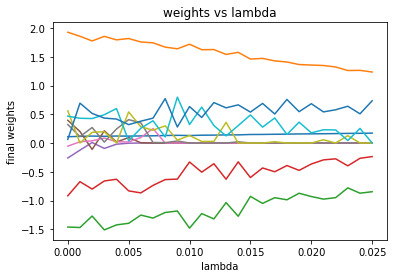

In [32]:
we = np.float32(we)
for i in range(len(we[0, :])):
    plt.plot(np.arange(0, 1, 0.001)[:len(we[:, i])], we[:, i])
    plt.xlabel('lambda')
    plt.ylabel('final weights')
    plt.title('weights vs lambda')
plt.show()

In [25]:
np.shape(we)

(29, 11)

## Taking values of weights<0.001 as zero

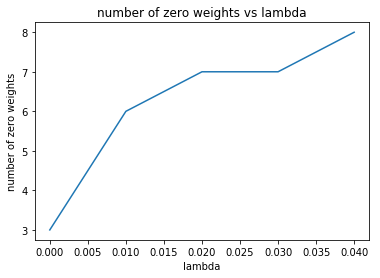

In [13]:
idx_plot = []
j = np.arange(0, 1, 0.01)
for i in range(len(we)):
    idx = np.where(we[i, :]<0.001)[0]
    idx_plot.append([len(idx), j[i]])
idx_plot = np.float32(idx_plot)
plt.plot(idx_plot[:, 1], idx_plot[:, 0])
plt.xlabel('lambda')
plt.ylabel('number of zero weights')
plt.title('number of zero weights vs lambda')
plt.show()

## exactly half weights <= 0.001

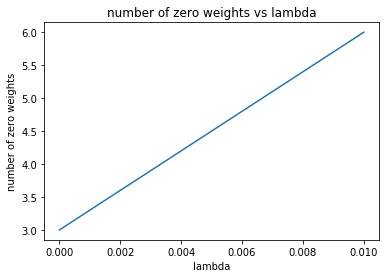

In [14]:
idx_plot = []
for i in range(len(we)):
    idx = np.where(we[i, :]<0.001)[0]
    idx_plot.append([len(idx), j[i]])
    if(len(idx)>=5):
        break
idx_plot = np.float32(idx_plot)
plt.plot(idx_plot[:, 1], idx_plot[:, 0])
plt.xlabel('lambda')
plt.ylabel('number of zero weights')
plt.title('number of zero weights vs lambda')
plt.show()